In [1]:
from nn_globals import *

from nn_encode import nlayers, nvariables

from nn_data import (muon_data_split, pileup_data_split, mix_training_inputs)

from nn_models import (create_model, create_model_bn, create_model_pruned, 
                       create_model_sequential, create_model_sequential_bn,
                       lr_decay, modelbestcheck, modelbestcheck_weights)

from nn_training import train_model

from nn_pruning import prune_model

%matplotlib inline

[INFO    ] Using cmssw CMSSW_10_1_7
[INFO    ] Using numpy 1.14.1
/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs_depscipy/3.0-omkpbe5/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
[INFO    ] Using tensorflow 1.5.0
Using TensorFlow backend.
[INFO    ] Using keras 2.1.4
[INFO    ] .. list devices: [_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]
[INFO    ] Using scipy 1.0.0
[INFO    ] Using sklearn 0.19.2


In [2]:
# Import muon data
# 'x' is the input variables with shape (n, 87), 'y' is the q/pT with shape (n, 1)
x_train, x_test, y_train, y_test, w_train, w_test, x_mask_train, x_mask_test = \
    muon_data_split(infile_muon, adjust_scale=adjust_scale, reg_pt_scale=reg_pt_scale, test_size=0.31)

# Add discrimator output node
if add_noise:
  labels = np.where(np.abs(1.0/y_train) >= discr_pt_cut/reg_pt_scale, 1., mask_value)
  y_train = [y_train, labels.astype(np.float32)]
  labels = np.where(np.abs(1.0/y_test) >= discr_pt_cut/reg_pt_scale, 1., mask_value)
  y_test = [y_test, labels.astype(np.float32)]
  
  #y_train = [y_train, np.ones((y_train.shape[0],), dtype=np.float32)]
  #y_test = [y_test, np.ones((y_test.shape[0],), dtype=np.float32)]

[INFO    ] Loading muon data from ../test7/histos_tba.18.npz ...
[INFO    ] Loaded the variables with shape (3274391, 87)
[INFO    ] Loaded the parameters with shape (3274391, 3)
[INFO    ] Loaded the encoded variables with shape (3274391, 43)
[INFO    ] Loaded the encoded parameters with shape (3274391,)
[INFO    ] Loaded # of training and testing events: (2259329, 1015062)


In [3]:
# Import pileup data
# 'x' is the input variables with shape (n, 87), 'aux' is pileup info with shape (n, 4)
pu_x_train, pu_x_test, pu_aux_train, pu_aux_test, pu_w_train, pu_w_test, pu_x_mask_train, pu_x_mask_test = \
    pileup_data_split(infile_pileup, adjust_scale=adjust_scale, reg_pt_scale=reg_pt_scale, test_job=131)

# Add output nodes for pileup data
if add_noise:
  pu_y_train = [np.full((pu_x_train.shape[0],), mask_value, dtype=np.float32), np.zeros((pu_x_train.shape[0],), dtype=np.float32)]
  pu_y_test = [np.full((pu_x_test.shape[0],), mask_value, dtype=np.float32), np.zeros((pu_x_test.shape[0],), dtype=np.float32)]

[INFO    ] Loading pileup data from ../test7/histos_tbd.18.npz ...
[INFO    ] Loaded the variables with shape (879536, 87)
[INFO    ] Loaded the auxiliary PU info with shape (879536, 4)
[INFO    ] Loaded the encoded variables with shape (879536, 43)
[INFO    ] Loaded the encoded auxiliary PU info with shape (879536, 4)
[INFO    ] Loaded # of training and testing events: (703515, 176021)


### Training

In [4]:
# Hello, what do you want to train today?

training_seq    = False
training_func   = False
training_bn     = False
training_pruned = False
training_adv    = True

In [5]:
# Training (Adversarial)

if training_adv:
  assert(keras.backend.backend() == 'tensorflow')
  
  if add_noise:
    x_train_new, y_train_new = mix_training_inputs(x_train, y_train, pu_x_train, pu_y_train, pu_aux_train, discr_pt_cut=discr_pt_cut, tile=4)
  else:
    raise Exception('add_noise must be set to True')

[INFO    ] Mixed muon data with pileup data. x_train_new has shape (4518658, 43), y_train_new has shape (4518658,),(4518658,)


In [6]:
import nn_acgan
reload(nn_acgan)

<module 'nn_acgan' from 'nn_acgan.pyc'>

In [7]:
if training_adv:
  acgan = nn_acgan.ACGAN()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                40        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                420       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 20)                0         
Total params: 880
Trainable params: 880
Non-trainable params: 0
_________________________________________________________________
____________

In [8]:
if training_adv:
  acgan.pre_train(x_train, y_train)

Train on 2033396 samples, validate on 225933 samples
Epoch 1/20
2033396/2033396 [==============================] - 18s 9us/step - loss: 18.8070 - model_2_loss: 18.8070 - model_1_loss: 0.0000e+00 - val_loss: 13.7879 - val_model_2_loss: 13.7879 - val_model_1_loss: 0.0000e+00
Epoch 2/20
2033396/2033396 [==============================] - 15s 7us/step - loss: 10.6179 - model_2_loss: 10.6179 - model_1_loss: 0.0000e+00 - val_loss: 7.9750 - val_model_2_loss: 7.9750 - val_model_1_loss: 0.0000e+00
Epoch 3/20
2033396/2033396 [==============================] - 14s 7us/step - loss: 6.4121 - model_2_loss: 6.4121 - model_1_loss: 0.0000e+00 - val_loss: 5.1408 - val_model_2_loss: 5.1408 - val_model_1_loss: 0.0000e+00
Epoch 4/20
2033396/2033396 [==============================] - 14s 7us/step - loss: 4.4301 - model_2_loss: 4.4301 - model_1_loss: 0.0000e+00 - val_loss: 3.8360 - val_model_2_loss: 3.8360 - val_model_1_loss: 0.0000e+00
Epoch 5/20
2033396/2033396 [==============================] - 14s 7us/ste

In [9]:
if training_adv:
  imgs = acgan.generator.predict(x_train_new, batch_size=4096)
  
  acgan.discriminator.fit(imgs, y_train_new[1], epochs=20, batch_size=256*4*4,
                          validation_split=0.1, verbose=1)
  
  acgan.combined.fit(x_train_new, y_train_new, epochs=20, batch_size=256*4*4, 
                     validation_split=0.1, verbose=1)

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs_depscipy/3.0-omkpbe5/lib/python2.7/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Train on 4066792 samples, validate on 451866 samples
Epoch 1/20
4066792/4066792 [==============================] - 11s 3us/step - loss: 0.1090 - acc: 0.5537 - val_loss: 0.0999 - val_acc: 0.5575
Epoch 2/20
4066792/4066792 [==============================] - 10s 3us/step - loss: 0.1014 - acc: 0.5570 - val_loss: 0.0996 - val_acc: 0.5576
Epoch 3/20
4066792/4066792 [==============================] - 11s 3us/step - loss: 0.1012 - acc: 0.5570 - val_loss: 0.0993 - val_acc: 0.5576
Epoch 4/20
4066792/4066792 [==============================] - 10s 3us/step - loss: 0.1010 - acc: 0.5570 - val_loss: 0.0991 - val_acc: 0.5575
Epoch 5/20
4066792/4066792 [==============================] - 10s 3us/step - loss: 0.1008 - acc: 0.5570 - val_loss: 0.0990 - val_acc: 0.5575
Epoch 6/20
4066792/4066792 [==============================] - 10s 3us/step - loss: 0.1006 - acc: 0.5570 - val_loss: 0.0987 - val_acc: 0.5576
Epoch 7/20
4066792/4066792 [==============================] - 11s 3us/step - loss: 0.1005 - acc: 0.55

### Regression Results

In [10]:
# Setup matplotlib
plt.style.use('tdrstyle.mplstyle')

from nn_plotting import (gaus, fit_gaus, np_printoptions, \
                         find_efficiency_errors)

eps = 1e-7
my_cmap = plt.cm.viridis
my_cmap.set_under('w',1)
my_palette = ("#377eb8", "#e41a1c", "#984ea3", "#ff7f00", "#4daf4a")

In [11]:
# Load model and predict outputs
#from nn_models import load_my_model, update_keras_custom_objects
#update_keras_custom_objects()
##K.set_learning_phase(0)
#loaded_model = load_my_model(name='model', weights_name='model_weights')
loaded_model = acgan.generator  #FIXME
loaded_model.trainable = False
assert not loaded_model.updates

nentries_test = x_test.shape[0]//4

# Prepare y_test_true, y_test_meas
y_test_true = y_test
if isinstance(y_test_true, list):
  y_test_true = y_test_true[0]
y_test_true = y_test_true[:nentries_test].copy()
y_test_true = y_test_true.reshape(-1)
y_test_true /= reg_pt_scale

y_test_meas = loaded_model.predict(x_test[:nentries_test], batch_size=4096)
if isinstance(y_test_meas, list):
  y_test_meas = y_test_meas[0]
y_test_meas = y_test_meas.reshape(-1)
y_test_meas /= reg_pt_scale
#print y_test_true.shape, y_test_true
#print y_test_meas.shape, y_test_meas

[INFO    ] # of entries: 253765, mean: -0.000661998405121, std: 0.0342035107315
[INFO    ] gaus fit (a, mu, sig): [2.55021382e+04 3.84199604e-05 2.13301101e-02]


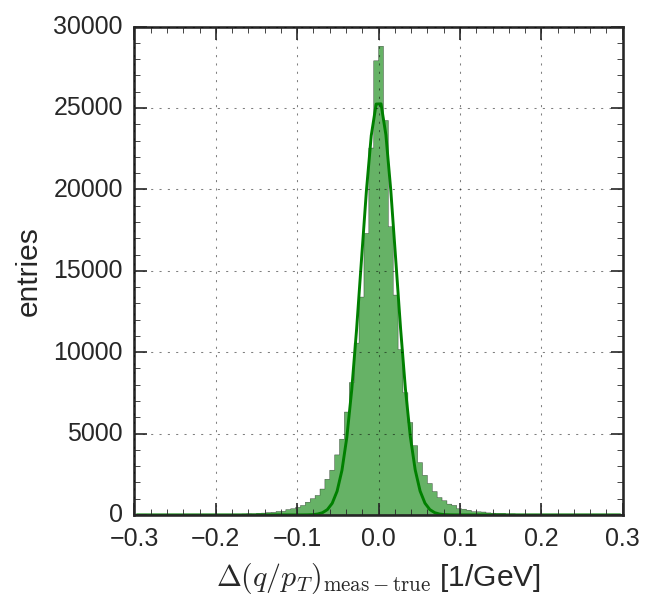

In [12]:
# Plot Delta(q/pT)
plt.figure()
yy = y_test_meas - y_test_true
hist, edges, _ = plt.hist(yy, bins=100, range=(-0.3,0.3-eps), histtype='stepfilled', facecolor='g', alpha=0.6)
plt.xlabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]')
plt.ylabel(r'entries')
logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.3])))

popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<0.3]))
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
xdata = (edges[1:] + edges[:-1])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
plt.show()

[INFO    ] # of entries: 253765, mean: 0.193915694952, std: 0.231825783849
[INFO    ] gaus fit (a, mu, sig): [2.99847290e+04 7.22958788e-03 1.19549045e-01]


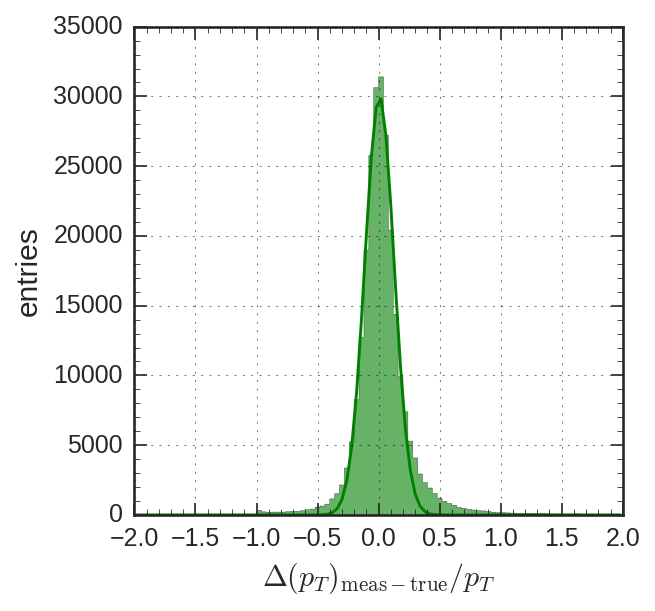

In [13]:
# Plot Delta(q/pT) / pT
plt.figure()
yy = (np.abs(1.0/y_test_meas) - np.abs(1.0/y_test_true))/np.abs(1.0/y_test_true)
hist, edges, _ = plt.hist(yy, bins=100, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
plt.xlabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$')
plt.ylabel(r'entries')
logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<2])))

popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<1.5]))
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
xdata = (edges[1:] + edges[:-1])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
plt.show()

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-matplotlib/1.5.2-omkpbe3/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


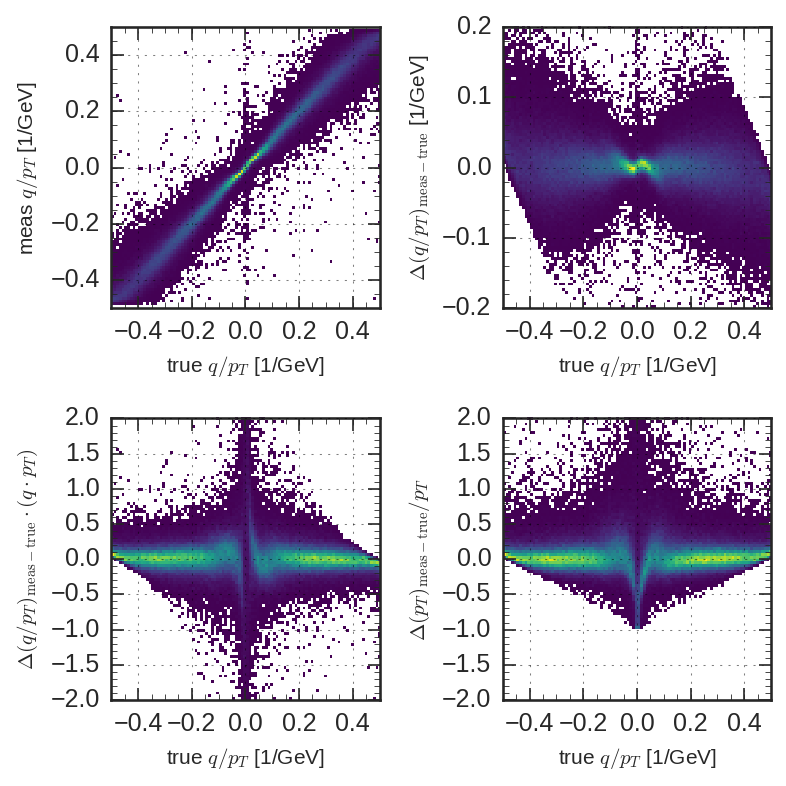

In [14]:
# Plot resolution plots
fig, axs = plt.subplots(2, 2, figsize=(5.4,5.4), tight_layout=True)

axs[0,0].hist2d(y_test_true, y_test_meas, bins=(100,100), range=((-0.5,0.5),(-0.5,0.5)), vmin=1, cmap=my_cmap)
axs[0,0].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[0,0].set_ylabel(r'meas $q/p_{T}$ [1/GeV]', fontsize=10)

yy = y_test_meas - y_test_true
axs[0,1].hist2d(y_test_true, yy, bins=(100,100), range=((-0.5,0.5),(-0.2,0.2)), vmin=1, cmap=my_cmap)
axs[0,1].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[0,1].set_ylabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]', fontsize=10)

yy = (y_test_meas - y_test_true)/np.abs(y_test_true)
axs[1,0].hist2d(y_test_true, yy, bins=(100,100), range=((-0.5,0.5),(-2,2)), vmin=1, cmap=my_cmap)
axs[1,0].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[1,0].set_ylabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}} \cdot (q \cdot p_{T})$', fontsize=10)

yy = (np.abs(1.0/y_test_meas) - np.abs(1.0/y_test_true))/np.abs(1.0/y_test_true)
axs[1,1].hist2d(y_test_true, yy, bins=(100,100), range=((-0.5,0.5),(-2,2)), vmin=1, cmap=my_cmap)
axs[1,1].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[1,1].set_ylabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=10)

plt.show()

In [15]:
# Make better resolution plot
xx = np.abs(y_test_true)
yy = (np.abs(1.0/y_test_meas) - np.abs(1.0/y_test_true))/np.abs(1.0/y_test_true)

nbinsx = 100
xedges = np.linspace(0, 0.5, num=nbinsx+1)
inds = np.digitize(xx, xedges[1:])

xxx = np.zeros(nbinsx, dtype=np.float32)
yyy = np.zeros(nbinsx, dtype=np.float32)
for i in xrange(nbinsx):
  xx_i = xx[inds==i]
  pt = np.mean(xx_i)
  pt = 1.0/pt
  
  yy_i = yy[inds==i]
  yy_i = yy_i[(-1 <= yy_i) & (yy_i <= 1.2)]
  mu, sig = np.mean(yy_i), np.std(yy_i)
  assert(np.abs(mu) < 1)
  assert(np.abs(sig) < 2)
  
  hist, edges = np.histogram(yy_i, bins=100, range=(-2,2))
  #popt = fit_gaus(hist, edges, mu=mu, sig=sig)
  popt = fit_gaus(hist, edges, mu=0.0, sig=0.2)
  #print i, len(xx_i), mu, sig, pt, popt
  
  if 20. < pt < 22.:
    xx_20GeV, yy_20GeV, popt_20GeV = xx_i, yy_i, popt
  
  xxx[i] = pt
  yyy[i] = popt[2]

[INFO    ] gaus fit (a, mu, sig): [2.24112194e+02 2.34721903e-02 1.92872927e-01]


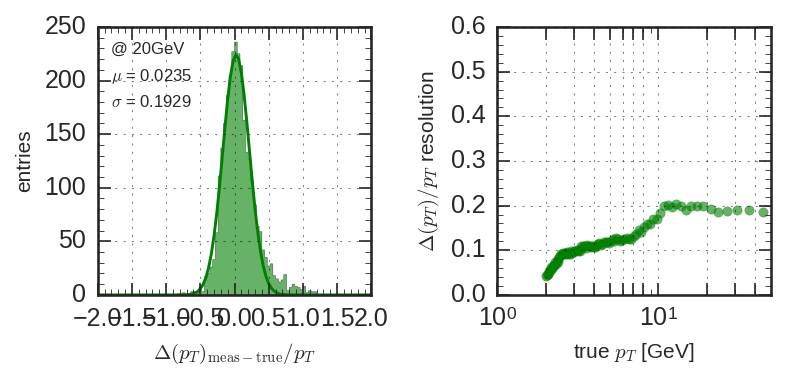

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(5.4,5.4/2), tight_layout=True)

#axs[0].hist2d(xx, yy, bins=(100,100), range=((0,0.5),(-1,3)), vmin=1, cmap=my_cmap)
#axs[0].set_xlabel(r'true $1/p_{T}$ [1/GeV]', fontsize=10)
#axs[0].set_ylabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=10)

hist, edges, _ = axs[0].hist(yy_20GeV, bins=100, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
popt = fit_gaus(hist, edges, mu=0.0, sig=0.2)
axs[0].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
axs[0].text(0.05, 0.9, r'@ 20GeV', transform=axs[0].transAxes, fontsize=8)
axs[0].text(0.05, 0.8, r'$\mu$ = {0:.4f}'.format(popt[1]), transform=axs[0].transAxes, fontsize=8)
axs[0].text(0.05, 0.7, r'$\sigma$ = {0:.4f}'.format(popt[2]), transform=axs[0].transAxes, fontsize=8)
axs[0].set_xlabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=10)
axs[0].set_ylabel(r'entries', fontsize=10)
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))

axs[1].scatter(xxx, yyy, color='g', alpha=0.6)
axs[1].set_xlim(1,50)
axs[1].set_ylim(0,0.6+eps)
axs[1].set_xlabel(r'true $p_{T}$ [GeV]', fontsize=10)
axs[1].set_ylabel(r'$\Delta(p_{T}) / p_{T}$ resolution', fontsize=10)
axs[1].set_xscale('log')
axs[1].set_xticks(range(1,9) + range(10,50,10))

plt.show()

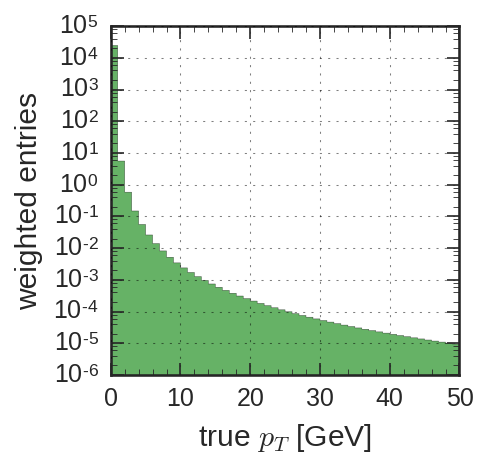

In [17]:
# Mock minbias pT spectrum
xx = np.linspace(0.1, 49.1, num=50)
#reweight = lambda x: 5.5 * np.power(x,-3)
#reweight = lambda x: 11 * np.power(x,-4)
reweight = lambda x: 7.778 * np.power(x,-3.5)
xw = np.fromiter((reweight(xi) for xi in xx), xx.dtype)

plt.figure(figsize=(3,3))
plt.hist(xx, bins=50, range=(0,50), weights=xw, histtype='stepfilled', facecolor='g', alpha=0.6)
plt.xlabel(r'true $p_{T}$ [GeV]')
plt.ylabel(r'weighted entries')
plt.yscale('log')
plt.show()

In [18]:
# Predict 20 GeV rates with 90% coverage
xx = np.abs(1.0/y_test_true)
yy = np.abs(1.0/y_test_meas)

reweight = lambda x, y, thresh: 7.778 * np.power(x,-2.5) if y >= thresh else 0.  # -2.5 instead of -3.5 because the parent distribution is already 1/pT-weighted

nbinsx = 20
xedges = np.linspace(2, 42, num=nbinsx+1)
inds = np.digitize(xx, xedges[1:])

xxx = np.zeros(nbinsx, dtype=np.float32)
for i in xrange(nbinsx):
  xx_i = xx[inds==i]
  yy_i = yy[inds==i]
  pct = np.percentile(yy_i, [10, 50, 90], overwrite_input=True)
  #print np.mean(xx_i), len(xx_i), pct
  
  xxx[i] = pct[0]

ind_20GeV = np.digitize(20., xedges[1:])
thresh_20GeV = xxx[ind_20GeV]
yw = np.fromiter((reweight(xi, yi, thresh_20GeV) for (xi, yi) in zip(xx, yy)), xx.dtype)
logger.info("20 GeV threshold {0} rate {1}".format(thresh_20GeV, np.sum(yw)))

ind_22GeV = np.digitize(22., xedges[1:])
thresh_22GeV = xxx[ind_22GeV]
yw = np.fromiter((reweight(xi, yi, thresh_22GeV) for (xi, yi) in zip(xx, yy)), xx.dtype)
logger.info("22 GeV threshold {0} rate {1}".format(thresh_22GeV, np.sum(yw)))

[INFO    ] 20 GeV threshold 16.8767356873 rate 154.49697876
[INFO    ] 22 GeV threshold 18.373960495 rate 121.593688965


In [19]:
print (y_test[0] != 0.).all()

True


### Classification Results

In [20]:
# Prepare y_test_true, y_test_meas (again)
y_test_true = [y_test[0][:nentries_test].copy(), y_test[1][:nentries_test].copy()]
y_test_meas = loaded_model.predict(x_test[:nentries_test], batch_size=4096)

y_test_meas_1 = acgan.discriminator.predict(y_test_meas, batch_size=4096)
y_test_meas = [y_test_meas, y_test_meas_1]  #FIXME

y_test_sel = (y_test_true[1] != mask_value)  # skip low pT muons
#y_test_true = [y_test_true[0], y_test_true[1]]
#y_test_meas = [y_test_meas[0], y_test_meas[1]]
y_test_true[0] /= reg_pt_scale
y_test_meas[0] /= reg_pt_scale
#print y_test_true[0].shape, y_test_true[0], y_test_true[1].shape, y_test_true[1]
#print y_test_meas[0].shape, y_test_meas[0], y_test_meas[1].shape, y_test_meas[1]

# Prepare pu_y_test_true, pu_y_test_meas
pu_y_test_sel = ~(pu_aux_test[:,2] > discr_pt_cut)  # veto PU events with high-pT tracks
pu_y_test_true = [pu_y_test[0].copy(), pu_y_test[1].copy()]
pu_y_test_meas = loaded_model.predict(pu_x_test, batch_size=4096)

pu_y_test_meas_1 = acgan.discriminator.predict(pu_y_test_meas, batch_size=4096)
pu_y_test_meas = [pu_y_test_meas, pu_y_test_meas_1]  #FIXME

#pu_y_test_meas = [pu_y_test_meas[0], pu_y_test_meas[1]]
#pu_y_test_true[0] /= reg_pt_scale
pu_y_test_meas[0] /= reg_pt_scale
#print pu_y_test_true[0].shape, pu_y_test_true[0], pu_y_test_true[1].shape, pu_y_test_true[1]
#print pu_y_test_meas[0].shape, pu_y_test_meas[0], pu_y_test_meas[1].shape, pu_y_test_meas[1]

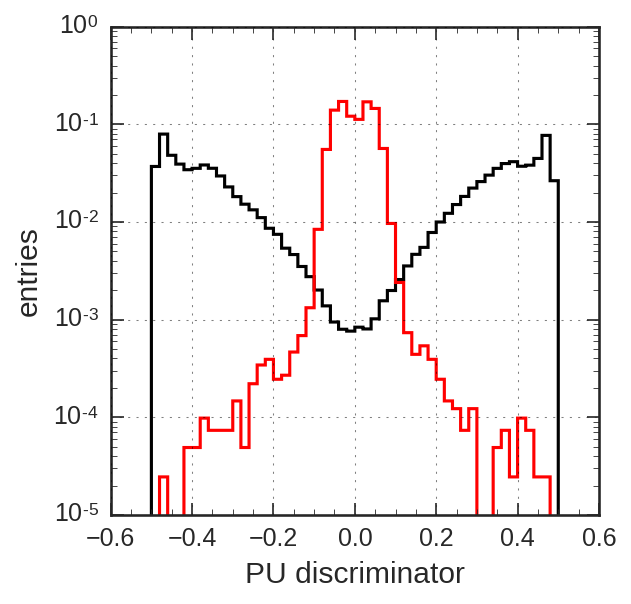

In [21]:
# Plot discriminator
plt.figure()
xx = pu_y_test_meas[0][pu_y_test_sel]
xw = np.ones_like(xx)/float(len(xx))
yy = y_test_meas[0][y_test_sel]
yw = np.ones_like(yy)/float(len(yy))

#plt.hist(xx, bins=50, range=(0,1), weights=xw, histtype='step', color='black', lw=1.5)
#plt.hist(yy, bins=50, range=(0,1), weights=yw, histtype='step', color='red', lw=1.5)
plt.hist(xx, bins=50, range=(-0.5,0.5), weights=xw, histtype='step', color='black', lw=1.5)
plt.hist(yy, bins=50, range=(-0.5,0.5), weights=yw, histtype='step', color='red', lw=1.5)
plt.xlabel(r'PU discriminator')
plt.ylabel(r'entries')
#plt.xlim(-0.1, 1.1)
#plt.ylim(1e-5, 2)
plt.yscale('log')
plt.show()

# Calculate separation score?

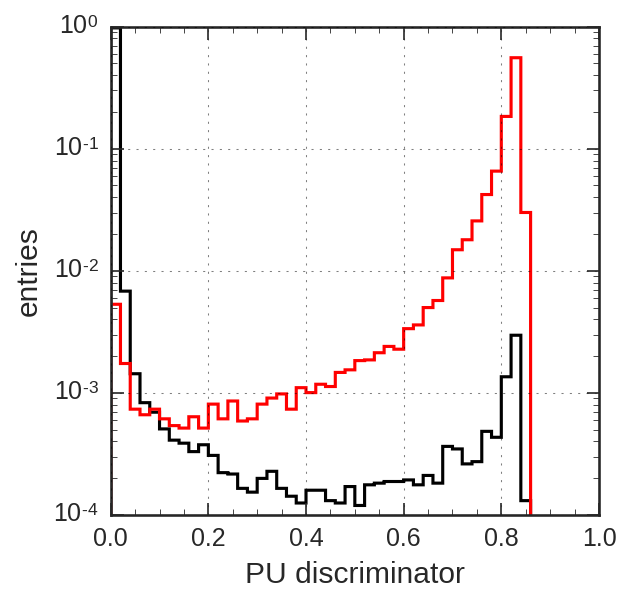

In [22]:
# Plot discriminator
plt.figure()
xx = pu_y_test_meas[1][pu_y_test_sel]
xw = np.ones_like(xx)/float(len(xx))
yy = y_test_meas[1][y_test_sel]
yw = np.ones_like(yy)/float(len(yy))

plt.hist(xx, bins=50, range=(0,1), weights=xw, histtype='step', color='black', lw=1.5)
plt.hist(yy, bins=50, range=(0,1), weights=yw, histtype='step', color='red', lw=1.5)
plt.xlabel(r'PU discriminator')
plt.ylabel(r'entries')
#plt.xlim(-0.1, 1.1)
#plt.ylim(1e-5, 2)
plt.yscale('log')
plt.show()

# Calculate separation score?

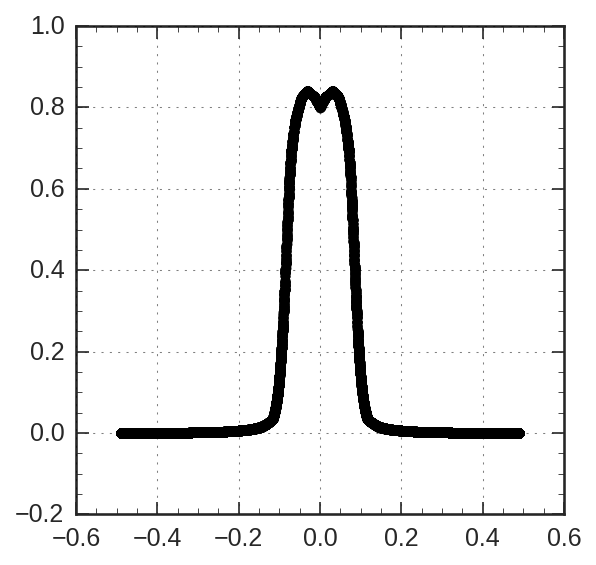

In [23]:
#plt.scatter(y_test_meas[0][y_test_sel], y_test_meas[1][y_test_sel], c='r')
plt.scatter(pu_y_test_meas[0][pu_y_test_sel], pu_y_test_meas[1][pu_y_test_sel], c='k')
plt.show()

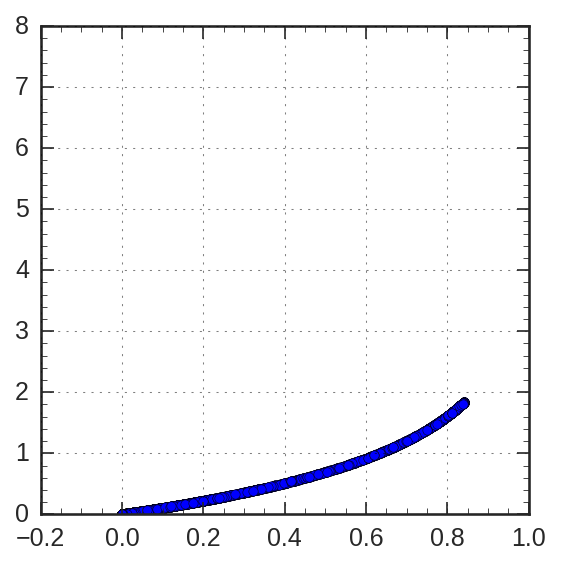

In [24]:
from nn_acgan import masked_binary_crossentropy

yy = masked_binary_crossentropy(K.cast(pu_y_test_true[1][pu_y_test_sel][:,np.newaxis], dtype=np.float32), K.cast(pu_y_test_meas[1][pu_y_test_sel], dtype=np.float32))
sess = K.get_session()
yy = sess.run(yy)

plt.scatter(pu_y_test_meas[1][pu_y_test_sel], yy)
plt.ylim(0,8)
plt.show()

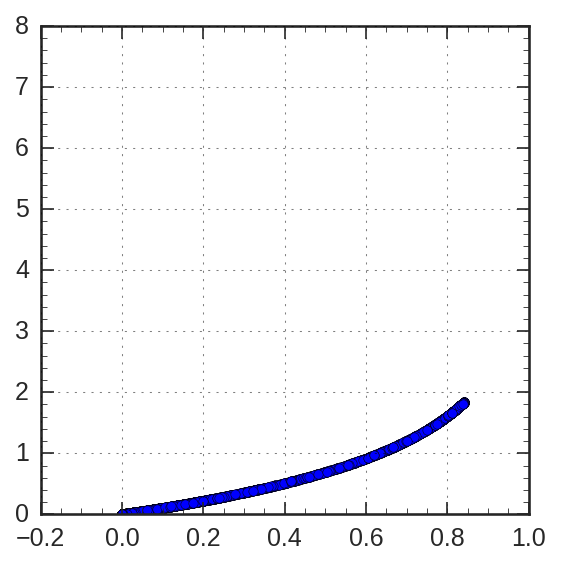

In [25]:
xx = pu_y_test_meas[1][pu_y_test_sel]
yy = -np.log(1-xx)
plt.scatter(xx, yy)
plt.ylim(0,8)
plt.show()

[INFO    ] auc: 0.996442851152
[INFO    ] thr: [0.7433, 0.7153, 0.6635, 0.5379, 0.3979, 0.2823, 0.1274, 0.0174, 0.0018]
[INFO    ] tpr: [0.9000, 0.9256, 0.9505, 0.9702, 0.9801, 0.9851, 0.9900, 0.9950, 0.9990]
[INFO    ] fpr: [0.0056, 0.0060, 0.0067, 0.0079, 0.0090, 0.0100, 0.0123, 0.0245, 0.1716]


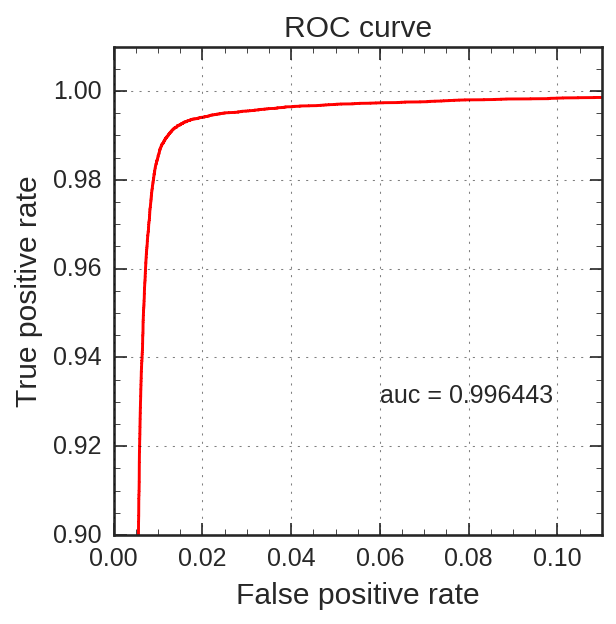

In [26]:
# Plot ROC
from sklearn.metrics import roc_curve, roc_auc_score

xx = np.concatenate((y_test_true[1][y_test_sel], pu_y_test_true[1][pu_y_test_sel]))[:, np.newaxis]
yy = np.concatenate((y_test_meas[1][y_test_sel], pu_y_test_meas[1][pu_y_test_sel]))
zz = np.concatenate((y_test_meas[0][y_test_sel], pu_y_test_meas[0][pu_y_test_sel]))

#yy = (1 - np.abs(yy)/0.5)  #FIXME

#zz_tmp = np.abs(1.0/zz) > discr_pt_cut  # meas pT > 14 GeV
#xx = xx[zz_tmp]
#yy = yy[zz_tmp]

fpr, tpr, thresh = roc_curve(xx, yy)  # (y_true, y_meas)
auc = roc_auc_score(xx, yy)           # (y_true, y_meas)

idx = np.searchsorted(tpr, [0.9, 0.925, 0.95, 0.97, 0.98, 0.985, 0.99, 0.995, 0.999])
logger.info("auc: {0}".format(auc))
logger.info("thr: {0}".format(np.array2string(thresh[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info("tpr: {0}".format(np.array2string(tpr[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info("fpr: {0}".format(np.array2string(fpr[idx], separator=', ', precision=4, floatmode='fixed')))

plt.figure()
plt.plot(fpr, tpr, 'r')
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.text(0.06, 0.93, r'auc = %f' % auc, fontsize=12)
plt.xlim(0.0,0.11)
plt.ylim(0.9,1.01)
plt.show()

### Efficiency & Rates 

In [27]:
# Build a trigger object

pt_bins = (-0.50, -0.333333, -0.25, -0.20, -0.15, -0.10, -0.05, 0.05, 0.10, 0.15, 0.20, 0.25, 0.333333, 0.50)

def find_pt_bin(pt):
  ipt = np.digitize((pt,), pt_bins[1:])[0]  # skip lowest edge
  ipt = np.clip(ipt, 0, len(pt_bins)-2)
  return ipt

def find_eta_bin(eta):
  ieta = np.digitize((abs(eta),), eta_bins[1:])[0]  # skip lowest edge
  ieta = np.clip(ieta, 0, len(eta_bins)-2)
  return ieta

def emtf_road_quality(ipt):
  best_ipt = find_pt_bin(0.)
  return best_ipt - abs(ipt - best_ipt)

def get_zone_from_x(x):
  assert(x.shape[0] == nvariables)
  zone = x[42-1] # 42th variable out of 43
  return int(zone * 6)

def get_straightness_from_x(x):
  assert(x.shape[0] == nvariables)
  straightness = x[41-1]  # 41th variable out of 43
  return int(straightness * 6) + 6

def get_ndof_from_x_mask(x_mask):
  assert(x_mask.shape[0] == nlayers)
  valid = ~x_mask
  return int(valid.sum())
  
def get_mode_from_x_mask(x_mask):
  assert(x_mask.shape[0] == nlayers)
  valid = ~x_mask
  mode = 0
  if np.any([valid[0], valid[1], valid[5], valid[9], valid[11]]):   # ME1/1, ME1/2, RE1/2, GE1/1, ME0 
    mode |= (1<<3)
  if np.any([valid[2], valid[6], valid[10]]):  # ME2, RE2, GE2/1
    mode |= (1<<2)
  if np.any([valid[3], valid[7]]):  # ME3, RE3
    mode |= (1<<1)
  if np.any([valid[4], valid[8]]):  # ME4, RE4
    mode |= (1<<0)
  return int(mode)

class TrackProducer(object):
  def __init__(self):
    self.s_min = 0.
    self.s_max = 60.
    self.s_nbins = 120
    self.s_step = (self.s_max - self.s_min)/self.s_nbins
    self.s_lut =[ 1.8033,  1.5274,  1.5763,  1.8237,  2.1879,  2.6230,  3.1155,  3.6518,
                  4.2155,  4.7967,  5.3908,  5.9994,  6.6244,  7.2684,  7.9308,  8.6053,
                  9.2908,  9.9948, 10.7298, 11.5099, 12.3237, 13.1229, 13.8880, 14.6376,
                 15.3812, 16.1308, 16.8973, 17.6784, 18.4520, 19.1901, 19.9247, 20.6816,
                 21.4334, 22.1444, 22.8086, 23.4463, 24.0783, 24.7172, 25.4073, 26.1606,
                 26.9364, 27.7242, 28.5276, 29.3725, 30.2838, 31.2058, 32.0224, 32.7878,
                 33.5877, 34.4098, 35.2421, 36.1414, 37.1000, 38.1562, 39.2171, 40.2058,
                 41.1481, 42.0277, 42.8997, 43.8268, 44.8314, 45.8833, 47.0336, 48.4881,
                 49.9129, 50.9945, 51.8567, 52.6797, 53.4950, 54.3078, 55.1194, 55.9304,
                 56.7411, 57.5516, 58.3620, 59.1722, 59.9824, 60.7926, 61.6027, 62.4127,
                 63.2228, 64.0328, 64.8429, 65.6529, 66.4629, 67.2729, 68.0829, 68.8929,
                 69.7029, 70.5129, 71.3229, 72.1328, 72.9428, 73.7528, 74.5628, 75.3727,
                 76.1827, 76.9927, 77.8026, 78.6126, 79.4226, 80.2326, 81.0425, 81.8525,
                 82.6625, 83.4724, 84.2824, 85.0924, 85.9023, 86.7123, 87.5223, 88.3322,
                 89.1422, 89.9522, 90.7621, 91.5721, 92.3821, 93.1920, 94.0020, 94.8120]
    #self.s_lut = np.linspace(self.s_min, self.s_max, num=self.s_nbins+1)[:-1]

  def get_trigger_pt(self, x, y_meas):
    xml_pt = np.abs(1.0/y_meas)
    if xml_pt <= 2.:  # do not use the LUT if below 2 GeV
      return xml_pt

    def digitize(x, bins=(self.s_nbins, self.s_min, self.s_max)):
      x = np.clip(x, bins[1], bins[2]-1e-8)
      binx = (x - bins[1]) / (bins[2] - bins[1]) * bins[0]
      return int(binx)

    def interpolate(x, x0, x1, y0, y1):
      y = (x - x0) / (x1 - x0) * (y1 - y0) + y0
      return y

    binx = digitize(xml_pt)
    if (binx+1) >= self.s_nbins:  # check boundary
      binx = self.s_nbins-2

    x0, x1 = binx * self.s_step, (binx+1) * self.s_step
    y0, y1 = self.s_lut[binx], self.s_lut[binx+1]
    pt = interpolate(xml_pt, x0, x1, y0, y1)
    return pt

  def pass_trigger(self, strg, ndof, trk_mode, y_meas, y_discr, discr_pt_cut=14.):
    ipt1 = strg
    ipt2 = find_pt_bin(y_meas)
    quality1 = emtf_road_quality(ipt1)
    quality2 = emtf_road_quality(ipt2)

    #if trk_mode in (11,13,14,15) and quality2 <= (quality1+1):
    #  if np.abs(1.0/y_meas) > discr_pt_cut:
    #    if ndof <= 3:
    #      trigger = (y_discr > 0.9934) # 90% coverage
    #    elif ndof == 4:
    #      trigger = (y_discr > 0.9843) # 95% coverage
    #    else:
    #      trigger = (y_discr > 0.9547) # 98.0% coverage
    #  else:
    #    trigger = (y_discr >= 0.)  # True
    #else:
    #  trigger = (y_discr < 0.)  # False
    trigger = trk_mode in (11,13,14,15) and quality2 <= (quality1+1)
    return trigger
  
  def run(self, slim_roads, variables, predictions, other_vars):
    assert(len(slim_roads) == len(variables))
    assert(len(slim_roads) == len(predictions))
    assert(len(slim_roads) == len(other_vars))

    tracks = []

    for myroad, myvars, mypreds, myother in izip(slim_roads, variables, predictions, other_vars):
      assert(len(myvars.shape) == 1)

      x = myvars
      x_mask = myother
      y_meas = np.asscalar(mypreds[...,0])
      y_discr = np.asscalar(mypreds[...,1])
      
      zone = get_zone_from_x(x)
      strg = get_straightness_from_x(x)
      ndof = get_ndof_from_x_mask(x_mask)
      mode = get_mode_from_x_mask(x_mask)
      
      passed = self.pass_trigger(strg, ndof, mode, y_meas, y_discr, discr_pt_cut=discr_pt_cut)
      xml_pt = np.abs(1.0/y_meas)
      pt = self.get_trigger_pt(x, y_meas)

      if passed:
        trk_q = np.sign(y_meas)
        trk_emtf_phi = myroad.id[4]
        trk_emtf_theta = myroad.theta_median
        trk = Track(myroad.id, myroad.hits, mode, xml_pt, pt, trk_q, trk_emtf_phi, trk_emtf_theta, ndof, y_discr)
        tracks.append(trk)
    return tracks

mytrigger = TrackProducer()

In [28]:
# Rates
rates_jobid_offset = 101
rates_njobs = 63
rates_nevents_per_job = 8000
rates_nevents_last_job = 2400
rates_nevents = 498400
assert(rates_nevents == (rates_njobs-1)*rates_nevents_per_job + rates_nevents_last_job)

# Stores highest track pt per event
rates_array = np.zeros((rates_njobs-1,rates_nevents_per_job), dtype=np.float32)
rates_array_last_job = np.zeros((1,rates_nevents_last_job), dtype=np.float32)

for ievt, (x, x_mask, y_meas, y_discr, aux) in enumerate(zip(pu_x_test, pu_x_mask_test, pu_y_test_meas[0], pu_y_test_meas[1], pu_aux_test)):
  zone = get_zone_from_x(x)
  strg = get_straightness_from_x(x)
  ndof = get_ndof_from_x_mask(x_mask)
  mode = get_mode_from_x_mask(x_mask)
  
  passed = mytrigger.pass_trigger(strg, ndof, mode, y_meas, y_discr, discr_pt_cut=discr_pt_cut)
  #xml_pt = np.abs(1.0/y_meas)
  pt = mytrigger.get_trigger_pt(x, y_meas)
  #pt_true = np.abs(1.0/y_true)
  
  (jobid, ievt, highest_part_pt, highest_track_pt) = aux
  jobid = int(jobid) - rates_jobid_offset
  ievt = int(ievt)
  
  if jobid < (rates_njobs-1):
    if passed:
      rates_array[jobid,ievt] = max(rates_array[jobid,ievt], pt)
  else:  # last job
    if passed:
      rates_array_last_job[0,ievt] = max(rates_array_last_job[0,ievt], pt)
  
  # Debug
  test_jobs = (31,50,56,60,)
  if jobid in test_jobs and passed and pt > 20.:
    print "{0:4.0f} {1:4.0f} {2:7.4f} {3:7.4f}".format(jobid, ievt, highest_part_pt, highest_track_pt), ndof, pt, y_discr
    if pt > 100.:  # wtf?
      with np_printoptions(precision=3, suppress=True):
        for lay in xrange(nlayers):
          tmp = np.arange(2) * nlayers + lay
          print "....", lay, x[tmp]

  31 2203  1.0994     nan 3 [30.578007] [0.8242062]
  31 2826 19.5646 30.0000 6 [32.740788] [0.8283295]
  31 2937 11.6057 19.5000 6 [60.154377] [0.8365488]
  31 2940  2.0375  3.0000 3 [33.31014] [0.8291085]
  31 3675  3.0667  8.5000 4 [47.59582] [0.8401089]
  31 3692 11.5982 17.0000 6 [20.320791] [0.7350862]
  31 3916  2.9307 72.5000 4 [65.446365] [0.8348005]
  31 4144  2.3670  8.0000 3 [44.138927] [0.8386343]
  31 4175  2.1073     nan 3 [96.65709] [0.8282627]
  31 4267  1.3803     nan 3 [24.411398] [0.79195297]
  31 4581  1.5532     nan 4 [39.391838] [0.83517253]
  31 4794  2.5811  3.0000 3 [21.657429] [0.7598888]
  31 5162  1.0764     nan 3 [125.19841] [0.8243168]
.... 0 [0.015 0.   ]
.... 1 [0. 0.]
.... 2 [0.157 0.   ]
.... 3 [-0.086  0.   ]
.... 4 [0. 0.]
.... 5 [0. 0.]
.... 6 [0. 0.]
.... 7 [0. 0.]
.... 8 [0. 0.]
.... 9 [0. 0.]
.... 10 [0. 0.]
.... 11 [0. 0.]
  31 5379 18.9197 30.5000 7 [26.466911] [0.80695033]
  31 5379 18.9197 30.5000 6 [24.880127] [0.7959811]
  31 5524  2.1671 

[INFO    ] nevents: 258400/498400


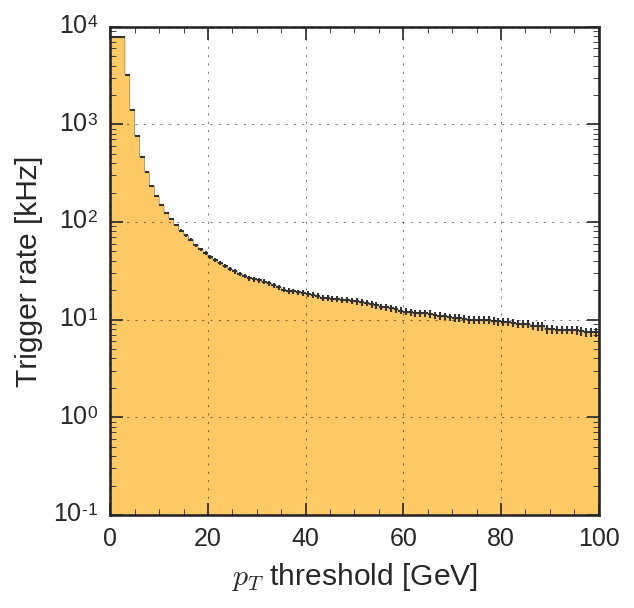

[INFO    ] Rates in kHz at 18/19/20/21/22 GeV: 52.4607230499, 47.9130441025, 43.5277825668, 41.1727346256, 38.2492269352


[7.7807e+03, 7.7807e+03, 7.7807e+03, 3.2370e+03, 1.4003e+03, 7.5264e+02,
 4.6240e+02, 3.2248e+02, 2.3477e+02, 1.8280e+02, 1.4780e+02, 1.2409e+02,
 1.0655e+02, 9.2821e+01, 8.1452e+01, 7.2844e+01, 6.5779e+01, 5.7983e+01,
 5.2461e+01, 4.7913e+01, 4.3528e+01, 4.1173e+01, 3.8249e+01, 3.5326e+01,
 3.2808e+01, 3.1184e+01, 2.9479e+01, 2.8017e+01, 2.6474e+01, 2.5987e+01,
 2.5256e+01, 2.4444e+01, 2.3550e+01, 2.2414e+01, 2.1358e+01, 2.0302e+01,
 1.9652e+01, 1.9490e+01, 1.9003e+01, 1.8840e+01, 1.8272e+01, 1.7947e+01,
 1.7460e+01, 1.6810e+01, 1.6729e+01, 1.6404e+01, 1.6323e+01, 1.5998e+01,
 1.5836e+01, 1.5511e+01, 1.5348e+01, 1.5024e+01, 1.4861e+01, 1.4293e+01,
 1.3968e+01, 1.3481e+01, 1.3318e+01, 1.3075e+01, 1.2750e+01, 1.2344e+01,
 1.2100e+01, 1.1856e+01, 1.1694e+01, 1.1694e+01, 1.1613e+01, 1.1450e+01,
 1.1126e+01, 1.0963e+01, 1.0882e+01, 1.0557e+01, 1.0395e+01, 1.0395e+01,
 1.0151e+01, 9.9887e+00, 9.9887e+00, 9.9074e+00, 9.9074e+00, 9.9074e+00,
 9.6638e+00, 9.5826e+00, 9.5014e+00, 9.4202e+00, 9.

In [29]:
# Rates
rates = np.concatenate((rates_array.reshape(-1), rates_array_last_job.reshape(-1)))
assert(len(rates) == rates_nevents)

# If the rates for a particular jobid is zero, assume the job has failed
rates_nevents_1 = 0
for jobid in xrange(rates_array.shape[0]):
  if rates_array[jobid].sum() > 0.:
    rates_nevents_1 += rates_nevents_per_job
if rates_array_last_job[0].sum() > 0.:
  rates_nevents_1 += rates_nevents_last_job
logger.info("nevents: {0}/{1}".format(rates_nevents_1, rates_nevents))  # should be half the statistics

expected_rates_nevents_1 = 258400
if rates_nevents_1 != expected_rates_nevents_1:
  logger.warning("rates_nevents_1 (which is {0}) != {1}, did some job fail?".format(rates_nevents_1, expected_rates_nevents_1))

def conversion_to_kHz(nevents):
  orbitFreq = 11245.6
  nCollBunches = 1866
  nZeroBiasEvents = nevents
  convFactorToHz = orbitFreq * nCollBunches / nZeroBiasEvents
  return (convFactorToHz / 1000.)

rates = rates[rates > eps]
rates = np.clip(rates, 0., 100.)
w = conversion_to_kHz(rates_nevents_1)
weights = np.full_like(rates, w)

plt.figure()
hist, edges, _ = plt.hist(rates, bins=100, range=(0.,100.), cumulative=-1, weights=weights, histtype='stepfilled', facecolor='orange', edgecolor='k', alpha=0.6)
xdata = (edges[1:] + edges[:-1])/2
xerr = (edges[1:] - edges[:-1])/2
ydata = hist
sumw2 = (ydata/w)
yerr = w*np.sqrt(sumw2)
plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color='#333333', ecolor='#333333', fmt='none', capsize=0, lw=1)
plt.xlabel(r'$p_{T}$ threshold [GeV]')
plt.ylabel(r'Trigger rate [kHz]')
plt.xlim(0,100)
plt.ylim(1e-1,1e4)
plt.yscale('log')
plt.show()

logger.info("Rates in kHz at 18/19/20/21/22 GeV: {0}, {1}, {2}, {3}, {4}".format(hist[18], hist[19], hist[20], hist[21], hist[22]))
print np.array2string(hist, separator=', ', precision=4, floatmode='fixed')